<a href="https://colab.research.google.com/github/werowe/deepstate-map-data/blob/main/2025_12_19_DeepStateMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here is an extensive explanation of the logic and techniques used in your Jupyter Notebook.

Following the explanation, I have provided a **Python script** that you can run to automatically generate the new, heavily annotated .ipynb file.

### **Part 1: Detailed Code Explanation**

This notebook performs a sophisticated geospatial Extract-Transform-Load (ETL) process. It scrapes live war-zone data, cleanses geometry, verifies data freshness, validates topology, and exports the result.

#### **1\. Data Extraction (The API Hack)**

The script essentially "hacks" the DeepStateMap frontend by calling its backend API directly.

* **Discovery:** The markdown explains using the Browser's "Network Tab" to find hidden API calls (XHR/Fetch).  
* **Request:** It uses requests.get() to hit https://deepstatemap.live/api/history/last.  
* **Significance:** Instead of scraping HTML (which is messy), this retrieves the raw GeoJSON data used to render the map, providing the highest possible fidelity.

#### **2\. Geometry Flattening (The 3D to 2D Fix)**

The raw data comes in (Longitude, Latitude, Altitude) or (X, Y, Z) format.

* **The Problem:** Most 2D mapping libraries (like Matplotlib or standard Shapefiles) struggle with the Z-axis (Altitude), or it causes errors during topological operations (like intersections).  
* **The Solution:** The code uses a serialization trick:  
  Python

```

wkt.loads(wkt.dumps(shape(geom), output_dimension=2))
```

*   
  It converts the shape to a text representation (WKT), forces it to 2 dimensions (dropping Z), and converts it back to a geometric object.

#### **3\. Data Parsing & Translation**

The name field in the raw data contains a string separated by /// (e.g., "Ukrainian Text /// English Text /// Code").

* **Logic:** A custom function extract\_first\_part splits this string and grabs index 1 (the English text) to make the dataset internationally readable.

#### **4\. Geospatial Filtering**

The dataset contains mixed types: Points (cities, events) and Polygons (territories).

* **Type Filtering:** gdf.geometry.apply(lambda x: isinstance(x, Polygon)) creates a mask to keep only territorial shapes, discarding points.  
* **Attribute Filtering:** It filters the dataframe for specific keys: \['CADR and CALR', 'Occupied', 'Occupied Crimea'\]. This isolates the Russian-controlled territories from liberated or contested zones.

#### **5\. Data Verification (The "Contains" Check)**

To ensure the map isn't stale, the script performs a "Point-in-Polygon" test.

* **Control Point:** A hardcoded coordinate (\_latest\_rus\_advance) representing a very recent frontline change is created.  
* **Logic:** occupied\_ua\_gdf\_raw.contains(point) checks if this new point physically sits inside the downloaded polygons. If True, the map data is current.

#### **6\. Topological Merging & Repair (The Buffer Trick)**

This is the most advanced part of the script.

* **Union:** union\_all() merges hundreds of small polygons into one giant shape (Multipolygon).  
* **Artifacts:** Merging often creates "slivers" or "ghost gaps" due to floating-point math errors at polygon boundaries.  
* **The Fix (Buffer/Debuffer):**  
  * **Buffer (+$\\epsilon$):** Expands the shape outward by a tiny fraction ($0.000009$). This forces edges to overlap and snaps gaps shut.  
  * **Buffer (-$\\epsilon$):** Shrinks the shape back by the same amount.  
  * **Result:** The general shape is preserved, but internal artifacts/holes are healed.

#### **7\. Validation & CRS Projection**

* **Projection:** Coordinates are transformed from EPSG:4326 (Lat/Lon, measured in degrees) to EPSG:9835 (a local projection for Donetsk/Ukraine, measured in meters).  
* **Area Check:** It calculates the area of the original shape vs. the healed shape. The difference is 0.000027%, proving the repair altered the geometry only microscopically (removing artifacts) without corrupting the data.

---

### **Part 2: Generator Script**

Run the following Python block. It will create a file named annotated\_DeepStateMap.ipynb in your current directory. This new file contains your original code, but broken down with Markdown cells explaining every step in detail, and inline comments for complex lines.

# What is Shapely

Shapely is a Python package used for the manipulation and analysis of planar geometric objects.​

Core Capabilities
It allows you to create geometric objects such as Points, LineStrings, and Polygons using standard Python classes. Once created, you can perform various operations on these objects, including:​

Set-theoretic operations: Union, intersection, difference, and symmetric difference.​

Constructive operations: Creating buffers, centroids, and convex hulls.​

Measurement: Calculating area, length, and distance between geometries.​



###Basic Usage Example
Here is how you might create a simple point and a line using Shapely:


`from shapely.geometry import Point, LineString`

### Create a point at coordinates (1, 1)
`point = Point(1, 1)`

### Create a line from three points
`line = LineString([(0, 0), (3, 1), (0, 3)])`

# DeepStateMap Geospatial ETL Pipeline

## 1. Environment Setup
Importing necessary libraries for HTTP requests (`requests`), handling geospatial dataframes (`geopandas`), geometric manipulation (`shapely`), and visualization (`matplotlib`).

In [ ]:
import requests
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely import wkt
from shapely.geometry import JOIN_STYLE
import matplotlib.pyplot as plt

## 2. API Extraction Strategy
Instead of scraping HTML, we target the backend API directly. This provides the raw GeoJSON data used by the website to render the map.

**Note:** This endpoint (`api/history/last`) retrieves the current state of the map.

In [ ]:
url = 'https://deepstatemap.live/api/history/last'

# Execute GET request to fetch raw map state
response = requests.get(url)

# Check HTTP 200 (Success)
response.status_code

200

In [ ]:
!date

Fri Dec 19 04:29:50 PM UTC 2025


## 3. Data Exploration & parsing
We parse the JSON response. The data is nested: `id` -> `map` -> `features`. The `features` list contains the actual geometric data.

In [ ]:
deep_state_data_raw = response.json()

# Inspect top-level keys to ensure structure matches expectations
print(deep_state_data_raw.keys())
print(deep_state_data_raw['map'].keys())

dict_keys(['id', 'map', 'datetime'])
dict_keys(['type', 'features'])


In [ ]:
deep_state_data_raw['map']['features']

[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[37.8413435, 48.6832309, 0],
     [37.8289785, 48.681153, 0],
     [37.8258865, 48.6764872, 0],
     [37.8360112, 48.6739748, 0],
     [37.829922, 48.660611, 0],
     [37.805553, 48.649176, 0],
     [37.80645, 48.638348, 0],
     [37.7938557, 48.6338159, 0],
     [37.7952349, 48.6249989, 0],
     [37.7743365, 48.6224808, 0],
     [37.76089, 48.612774, 0],
     [37.763666, 48.600853, 0],
     [37.781832, 48.594208, 0],
     [37.7900567, 48.5947081, 0],
     [37.7924885, 48.5914907, 0],
     [37.7925457, 48.5895414, 0],
     [37.798096, 48.5898629, 0],
     [37.803217, 48.591149, 0],
     [37.80758, 48.591422, 0],
     [37.809174, 48.589303, 0],
     [37.808794, 48.586617, 0],
     [37.813714, 48.586386, 0],
     [37.815831, 48.582636, 0],
     [37.82151, 48.57971, 0],
     [37.828016, 48.577931, 0],
     [37.833154, 48.576184, 0],
     [37.832539, 48.570307, 0],
     [37.840678, 48.563293, 0],
     [37.8309175, 4

## 4. Geometry flattening (3D to 2D)
**Critical Step:** The API returns coordinates in `(x, y, z)` format (Longitude, Latitude, Altitude). Most 2D analysis tools fail if Z-coordinates are present.

We loop through the features and use `shapely.wkt` to serialize the shape to text while forcing `output_dimension=2`, effectively dropping the Z-axis.

In [ ]:
geo_list = []

for f in deep_state_data_raw['map']['features']:
    geom = f['geometry']
    name = f['properties']['name']

    # Convert raw dict to Shape object -> Dump to WKT (Text) forcing 2D -> Load back to Shape
    # This effectively strips the 'Z' coordinate
    clean_geometry = wkt.loads(wkt.dumps(shape(geom), output_dimension=2))

    new_feature = {
      "name": name,
      "geometry": clean_geometry
    }

    geo_list.append(new_feature)

# Check total count of features retrieved
print(f"Total features extracted: {len(geo_list)}")

Total features extracted: 523


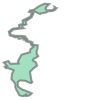

In [ ]:
geo_list[0]['geometry']

In [ ]:
print(geo_list[0]['geometry'])

POLYGON ((37.8413435 48.6832309, 37.8289785 48.681153, 37.8258865 48.6764872, 37.8360112 48.6739748, 37.829922 48.660611, 37.805553 48.649176, 37.80645 48.638348, 37.7938557 48.6338159, 37.7952349 48.6249989, 37.7743365 48.6224808, 37.76089 48.612774, 37.763666 48.600853, 37.781832 48.594208, 37.7900567 48.5947081, 37.7924885 48.5914907, 37.7925457 48.5895414, 37.798096 48.5898629, 37.803217 48.591149, 37.80758 48.591422, 37.809174 48.589303, 37.808794 48.586617, 37.813714 48.586386, 37.815831 48.582636, 37.82151 48.57971, 37.828016 48.577931, 37.833154 48.576184, 37.832539 48.570307, 37.840678 48.563293, 37.8309175 48.5560509, 37.8288819 48.5460225, 37.8021781 48.5382795, 37.7901461 48.5166537, 37.792583 48.5096988, 37.7659563 48.5085208, 37.7594723 48.5176633, 37.7444044 48.512818, 37.7554688 48.5019895, 37.74735 48.4990934, 37.7514447 48.4946879, 37.7600022 48.4942635, 37.7767603 48.4876684, 37.7710021 48.475259, 37.7694621 48.458737, 37.7773587 48.4506954, 37.7826679 48.4409565, 37

## 5. Metadata Translation
The `name` field is formatted as `Ukrainian /// English /// Code`. We create a utility to split this string and retain only the English label.

In [ ]:
def extract_first_part(name, part=0):
    """Splits the DeepState name string and returns the specific index requested."""
    first_part = name.split('///')[part].strip()
    return first_part

# Apply translation to all items in the list (Index 1 = English)
for item in geo_list:
    item['name'] = extract_first_part(item['name'], part=1)

# Verify the first item is now English
print(geo_list[0])

{'name': 'Unknown status', 'geometry': <POLYGON ((37.841 48.683, 37.829 48.681, 37.826 48.676, 37.836 48.674, 37.83...>}


## 6. GeoDataFrame Construction
We convert the list of dicts into a `GeoDataFrame`. We explicitly set the CRS (Coordinate Reference System) to **EPSG:4326** (WGS84 - Standard Latitude/Longitude).

## Explanation of code below

1. `raw_deepstatemap_gdf = gpd.GeoDataFrame(geo_list)`
What it does: This converts geo_list (which is a standard Python list of dictionaries) into a GeoDataFrame.

Why it matters: A GeoDataFrame is the core data structure of the geopandas library. It looks like a standard Excel spreadsheet or Pandas DataFrame, but it has a special "geometry" column that understands shapes (Points, Polygons). This allows you to perform spatial operations like calculating areas, merging boundaries, or checking if a point is inside a region.

2. `raw_deepstatemap_gdf = raw_deepstatemap_gdf.set_crs(4326)`
What it does: This tells the GeoDataFrame that the coordinates inside it are using the EPSG:4326 standard.

The Translation: EPSG:4326 is the code for WGS84, which is the standard latitude/longitude system used by GPS, Google Maps, and most online mapping tools.

Why it matters: Without this line, the computer just sees numbers like (37.5, 48.2). By setting the CRS, you are telling the computer, "These numbers represent degrees on the curved surface of the Earth." This is critical for accurate mapping and area calculations later.

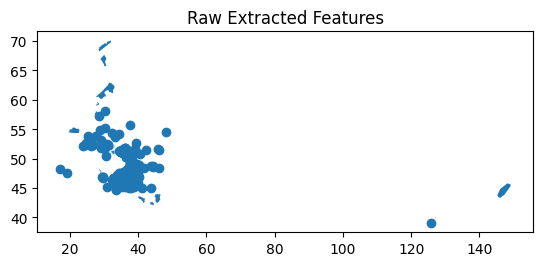

In [ ]:
raw_deepstatemap_gdf = gpd.GeoDataFrame(geo_list)
raw_deepstatemap_gdf = raw_deepstatemap_gdf.set_crs(4326)

# Visual inspection of the raw data
raw_deepstatemap_gdf.plot()
plt.title("Raw Extracted Features")
plt.show()

## Why does this Object Appear as a Shape and not Coordinates

Based on the code in your notebook, raw_deepstatemap_gdf is a GeoDataFrame, and the elements in its 'geometry' column are Shapely objects (specifically Polygon objects).

Google Colab (and Jupyter Notebooks) draws this as an image because of a specific feature in the Shapely library designed for notebooks:

**Rich Display System**: Notebooks always look for special methods to display objects nicely.

`_repr_svg_` Method: Shapely geometry objects contain a method called `_repr_svg_()`. When you output a geometry object at the end of a cell, Colab detects this method and automatically renders the geometry as an SVG image (a "mini map" or drawing) instead of printing the text representation.

### How to get the raw coordinates instead
To force Colab to show you the text/coordinates, you need to bypass the rich display. You can do this in three ways:

Wrap it in print() (Forces text output):



`print(raw_deepstatemap_gdf['geometry'][0])`
Access the .wkt attribute (Well-Known Text format):



`raw_deepstatemap_gdf['geometry'][0].wkt`
Access the .bounds or .exterior.coords (For raw numeric data):


# To see the list of coordinate tuples
`list(raw_deepstatemap_gdf['geometry'][0].exterior.coords)`

## Plot on Map

Uses these websites:

1. https://arthur-e.github.io/Wicket/


2. https://clydedacruz.github.io/openstreetmap-wkt-playground/


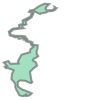

In [ ]:
raw_deepstatemap_gdf['geometry'][0]

In [ ]:
raw_deepstatemap_gdf['name'][0]

'Unknown status'

In [ ]:
print(raw_deepstatemap_gdf['geometry'][0].wkt )

POLYGON ((37.8413435 48.6832309, 37.8289785 48.681153, 37.8258865 48.6764872, 37.8360112 48.6739748, 37.829922 48.660611, 37.805553 48.649176, 37.80645 48.638348, 37.7938557 48.6338159, 37.7952349 48.6249989, 37.7743365 48.6224808, 37.76089 48.612774, 37.763666 48.600853, 37.781832 48.594208, 37.7900567 48.5947081, 37.7924885 48.5914907, 37.7925457 48.5895414, 37.798096 48.5898629, 37.803217 48.591149, 37.80758 48.591422, 37.809174 48.589303, 37.808794 48.586617, 37.813714 48.586386, 37.815831 48.582636, 37.82151 48.57971, 37.828016 48.577931, 37.833154 48.576184, 37.832539 48.570307, 37.840678 48.563293, 37.8309175 48.5560509, 37.8288819 48.5460225, 37.8021781 48.5382795, 37.7901461 48.5166537, 37.792583 48.5096988, 37.7659563 48.5085208, 37.7594723 48.5176633, 37.7444044 48.512818, 37.7554688 48.5019895, 37.74735 48.4990934, 37.7514447 48.4946879, 37.7600022 48.4942635, 37.7767603 48.4876684, 37.7710021 48.475259, 37.7694621 48.458737, 37.7773587 48.4506954, 37.7826679 48.4409565, 37

## 7. Data Cleaning & Filtering
The dataset contains mixed geometries (Points for events/cities, Polygons for territories). We filter to keep **only Polygons**.

# Here we change this

We want to modify this code to keep points, like airports and position of troops.  He throws those away here.

But doing that will mess up other code below.  So let's make a point object and save it.  

In [ ]:
points = raw_deepstatemap_gdf[
    raw_deepstatemap_gdf.geometry.apply(lambda x: isinstance(x, Point))
].copy()

print(f"Polygons remaining: {len(points)}")

Polygons remaining: 408


In [ ]:
points

,name,geometry
109,Russian cruiser Moskva,POINT (30.92515 45.17872)
110,Direction of attack,POINT (36.82591 48.06571)
111,Direction of attack,POINT (37.70018 49.50677)
112,Kyiv,POINT (30.52424 50.45006)
113,Minsk,POINT (27.55887 53.90216)
...,...,...
518,Air Base Ostrov,POINT (28.42118 57.29159)
519,Akhtubinsk Aerodrom,POINT (46.20243 48.30862)
520,Volgograd International Airport,POINT (44.34387 48.78517)
521,Airport «Vytyazevo»,POINT (37.34117 45.00282)


In [ ]:
points.iloc[0]

,109
name,Russian cruiser Moskva
geometry,POINT (30.925149 45.178719)


In [ ]:
# Filter: Keep rows where geometry is a Polygon
deepstatemap_gdf = raw_deepstatemap_gdf[
    raw_deepstatemap_gdf.geometry.apply(lambda x: isinstance(x, Polygon))
].copy()

print(f"Polygons remaining: {len(deepstatemap_gdf)}")

Polygons remaining: 115


# This gives us unique names

This gives us unique names of the items on the map. So an increase in the total area of Liberated areas is what he is interested in.  This is territory that Ukrain has taken back from Russia.  It is the change in this area that we are interested in.

In [ ]:
deepstatemap_gdf['name'].unique()

array(['Unknown status', 'Occupied', 'Transnistria',
       'Occupied Tskhinvali district', 'Occupied Tuzla Island',
       'CADR and CALR', 'Occupied Crimea',
       'East Prussia is temporarily occupied.', 'Occupied Abkhazia.',
       'The temporarily occupied territory of Karelia.',
       'The temporarily occupied territory of the Republic of Ichkeria.',
       'Liberated', 'Liberated 25.03', 'Liberated 16.03-17.03',
       'Liberated 23.03', 'Liberated 27-31.03', 'Liberated 26.03',
       'Liberated 27-29.03', 'Liberated 30.03', 'Liberated 05.04',
       'Liberated 31.03', 'Liberated 02.07', 'Liberated 30.05',
       'Snake Island', 'Liberated 26.06', 'Liberated 04.09',
       'Occupied Petsamo', 'Occupied Salla',
       'occupied Estonia territories.',
       'Occupied Pechorsky district (Saaste Boot).',
       'Occupied Latvia territories.', 'Occupied Southern Kuril islands.',
       'Liberated 31.03 - 02.04'], dtype=object)

## 8. Identifying Occupied Territories
We filter specifically for names associated with Russian occupation (`Occupied`, `Occupied Crimea`, etc). This discards 'Liberated' or 'Grey Zone' areas.

In [ ]:
targets = ['CADR and CALR', 'Occupied', 'Occupied Crimea']

occupied_ua_gdf_raw = deepstatemap_gdf[
    deepstatemap_gdf['name'].isin(targets)
].copy().reset_index()

occupied_ua_gdf_raw.plot(cmap='viridis')
plt.title("Filtered Occupied Territories")
plt.show()

NameError: name 'deepstatemap_gdf' is not defined

## 9. Data Freshness Verification (Point-in-Polygon)
To validate the data is not stale, we define a point (`_latest_rus_advance`) known to be recently occupied.

We use the `.contains()` method. If the point lies inside our polygon set, the map data includes the latest updates.

Data Freshness Confirmed: True


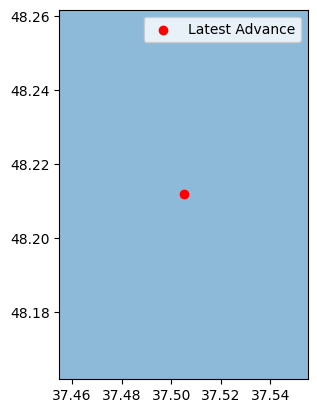

In [ ]:
# Define a control point (Lat/Lon)
_latest_rus_advance = Point(37.50500679016114, 48.21177662359289)

# Check if this point exists within any of the occupied polygons
is_up_to_date = occupied_ua_gdf_raw.contains(_latest_rus_advance).any()

print(f"Data Freshness Confirmed: {is_up_to_date}")

# Visual Verification
fig, ax = plt.subplots()
occupied_ua_gdf_raw.plot(ax=ax, alpha=0.5)
ax.scatter(_latest_rus_advance.x, _latest_rus_advance.y, color='red', marker='o', label='Latest Advance')

# Zoom in on the point
buffer = 0.05
ax.set_xlim(_latest_rus_advance.x - buffer, _latest_rus_advance.x + buffer)
ax.set_ylim(_latest_rus_advance.y - buffer, _latest_rus_advance.y + buffer)
plt.legend()
plt.show()

## 10. Topology Repair (The Buffer Trick)
We merge all individual polygons into one `MultiPolygon` using `union_all()`. However, computational math often leaves microscopic gaps (slivers) between touching polygons.

**The Fix:**
1. **Buffer (+epsilon):** Expand the shape slightly to overlap and close gaps.
2. **Buffer (-epsilon):** Shrink the shape back to original size.

We use `JOIN_STYLE.mitre` to preserve sharp corners.

/tmp/ipython-input-2452317257.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  .buffer(eps, 1, join_style=JOIN_STYLE.mitre)  # Expand
/tmp/ipython-input-2452317257.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  .buffer(-eps, 1, join_style=JOIN_STYLE.mitre) # Shrink


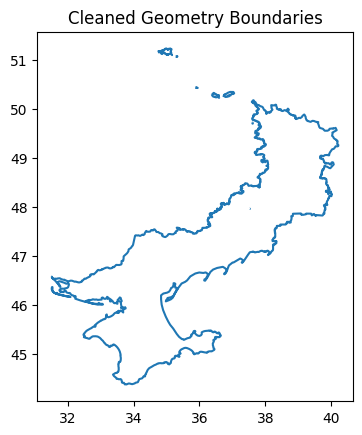

In [ ]:
# 1. Create a single fused geometry
occupied_ua_gsr = gpd.GeoSeries(occupied_ua_gdf_raw.union_all(), crs=4326)

# 2. Apply Buffer/Debuffer trick to remove artifacts
eps = 0.000009 # Epsilon value (tiny distance)

occupied_ua = (
    occupied_ua_gsr
    .buffer(eps, 1, join_style=JOIN_STYLE.mitre)  # Expand
    .buffer(-eps, 1, join_style=JOIN_STYLE.mitre) # Shrink
    .to_crs(4326)
    .copy()
)

# Plot boundaries to ensure no internal artifacts remain
occupied_ua.boundary.plot()
plt.title("Cleaned Geometry Boundaries")
plt.show()

## 11. Statistical Validation
Did the buffer trick distort the map? We check the area difference.

**Note:** We calculate area using `EPSG:9835` (UCS-2000), a projection system specifically accurate for the Donetsk region, rather than using generic Lat/Lon degrees.

In [ ]:
# Calculate area difference between raw and cleaned versions using local projection
area_cleaned = occupied_ua.to_crs(9835).area.sum()
area_raw = occupied_ua_gsr.to_crs(9835).area.sum()

pct_diff = abs((area_cleaned - area_raw) / area_raw) * 100

print(f"Area Difference: {pct_diff:.6f}%")
if pct_diff < 0.01:
    print("Validation Passed: Topology repair did not distort geometry.")

Area Difference: 0.000022%
Validation Passed: Topology repair did not distort geometry.


## 12. Export
Saving the finalized, cleaned, and verified geometry to GeoJSON.

In [ ]:
occupied_ua.to_crs(4326).to_file("occupied-areas-ua.geojson", driver="GeoJSON")
print("Export Complete.")

Export Complete.


# My Experiments

In [ ]:
from ipyleaflet import Map, basemaps, GeoJSON
from shapely import wkt
import json


wkt_str = """
POLYGON ((37.8413435 48.6832309, 37.8289785 48.681153, 37.8258865 48.6764872, 37.8360112 48.6739748, 37.829922 48.660611, 37.805553 48.649176, 37.80645 48.638348, 37.7938557 48.6338159, 37.7952349 48.6249989, 37.7743365 48.6224808, 37.76089 48.612774, 37.763666 48.600853, 37.781832 48.594208, 37.7900567 48.5947081, 37.7924885 48.5914907, 37.7925457 48.5895414, 37.798096 48.5898629, 37.803217 48.591149, 37.80758 48.591422, 37.809174 48.589303, 37.808794 48.586617, 37.813714 48.586386, 37.815831 48.582636, 37.82151 48.57971, 37.828016 48.577931, 37.833154 48.576184, 37.832539 48.570307, 37.840678 48.563293, 37.8309175 48.5560509, 37.8288819 48.5460225, 37.8021781 48.5382795, 37.7901461 48.5166537, 37.792583 48.5096988, 37.7659563 48.5085208, 37.7594723 48.5176633, 37.7444044 48.512818, 37.7554688 48.5019895, 37.74735 48.4990934, 37.7514447 48.4946879, 37.7600022 48.4942635, 37.7767603 48.4876684, 37.7710021 48.475259, 37.7694621 48.458737, 37.7773587 48.4506954, 37.7826679 48.4409565, 37.781333 48.4355116, 37.7838841 48.4270649, 37.7939421 48.409429, 37.7943473 48.4072839, 37.8062326 48.4035957, 37.809966 48.405953, 37.816232 48.404007, 37.817607 48.404658, 37.817309 48.406587, 37.817879 48.406967, 37.816402 48.409434, 37.817208 48.40977, 37.818701 48.4072, 37.81875 48.40675, 37.822765 48.4047187, 37.8304481 48.4083192, 37.8351284 48.4132865, 37.8097601 48.4239026, 37.8065637 48.4239088, 37.7913452 48.4344178, 37.7896011 48.4406549, 37.7901472 48.4499942, 37.7971415 48.4549598, 37.8140995 48.4538819, 37.8327247 48.445798, 37.8370389 48.4499077, 37.834365 48.453136, 37.830919 48.472528, 37.829497 48.48317, 37.8430116 48.4960845, 37.8523558 48.5027041, 37.848826 48.513189, 37.8383289 48.5196546, 37.8415883 48.5251115, 37.8515699 48.529906, 37.8560549 48.5336868, 37.8510977 48.5405936, 37.8506692 48.5501475, 37.853233 48.55549, 37.854594 48.568472, 37.841239 48.570267, 37.837702 48.571583, 37.83777 48.574148, 37.837734 48.578143, 37.8344 48.578295, 37.832281 48.580757, 37.82467 48.581572, 37.820656 48.584733, 37.821106 48.58816, 37.818144 48.590592, 37.817543 48.593017, 37.808635 48.592126, 37.808559 48.593604, 37.813675 48.595394, 37.813393 48.597669, 37.804326 48.59899, 37.782024 48.599128, 37.766901 48.602, 37.76508 48.610661, 37.7764591 48.619809, 37.8088309 48.6237667, 37.8044811 48.6265946, 37.8049227 48.6318113, 37.817853 48.635957, 37.814656 48.6454, 37.8350334 48.6595383, 37.8411654 48.6727992, 37.8392072 48.6753634, 37.8346738 48.6765673, 37.8355478 48.6796415, 37.8428594 48.6784652, 37.855883 48.672342, 37.861776 48.669412, 37.865103 48.671647, 37.883278 48.675242, 37.887105 48.678506, 37.901281 48.679053, 37.911087 48.683402, 37.910775 48.684626, 37.915522 48.688725, 37.910438 48.690366, 37.910612 48.69161, 37.908209 48.692828, 37.909116 48.690306, 37.908195 48.686898, 37.900065 48.681508, 37.896336 48.682411, 37.893723 48.682352, 37.889651 48.68181, 37.885493 48.680306, 37.879885 48.686278, 37.881258 48.69149, 37.89168 48.701717, 37.8765147 48.7030232, 37.8604408 48.6959742, 37.8413435 48.6832309))

"""

poly = wkt.loads(wkt_str)

# Shapely uses (x, y) = (lon, lat); Leaflet expects [lat, lon]
coords_lonlat = list(poly.exterior.coords)
coords_latlon = [[lat, lon] for lon, lat in coords_lonlat]

geojson = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [coords_lonlat],  # GeoJSON expects [lon, lat]
    },
    "properties": {"name": "My polygon"},
}

# Center map on polygon centroid
centroid = poly.centroid
m = Map(
    center=(centroid.y, centroid.x),
    zoom=11,
    basemap=basemaps.OpenStreetMap.Mapnik  # DeepState uses MapTiler, but OSM is fine visually
)

layer = GeoJSON(
    data=geojson,
    style={
        "color": "red",
        "weight": 2,
        "fillColor": "red",
        "fillOpacity": 0.4,
    }
)

m.add(layer)



Map(center=[48.5282003069053, 37.8152856122885], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

# How to add a LARGE point to a map

In [ ]:
from ipyleaflet import Map, basemaps, GeoJSON, Marker, DivIcon
from shapely import wkt
import json

# 1. Your existing Polygon

poly = wkt.loads(wkt_str)
coords_lonlat_poly = list(poly.exterior.coords)

# 2. The NEW Point
point_wkt_str = "POINT (37.7001777 49.5067677)"
point_geom = wkt.loads(point_wkt_str)

# 3. Create Map (Centered on polygon)
centroid = poly.centroid
m = Map(
    center=(centroid.y, centroid.x),
    zoom=9, # Zoomed out a bit to see both shapes
    basemap=basemaps.OpenStreetMap.Mapnik
)

# 4. Add Polygon Layer
poly_geojson = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [coords_lonlat_poly],
    },
    "properties": {"name": "My Polygon"},
}
poly_layer = GeoJSON(
    data=poly_geojson,
    style={"color": "red", "weight": 2, "fillColor": "red", "fillOpacity": 0.4}
)
m.add(poly_layer)

# 5. Add Point Layer (NEW STEP)
# Convert shapely point to GeoJSON format: [lon, lat]
point_geojson = {
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [point_geom.x, point_geom.y],
    },
    "properties": {"name": "My Point"},
}



point_layer = GeoJSON(
    data=point_geojson,
    point_style={
        "radius": 20,          # Large size
        "color": "red",        # Red border
        "fillColor": "red",    # Red fill
        "fillOpacity": 0.8,    # Solid fill
        "weight": 3            # Thick border
    }
)

m.add(point_layer)

label_marker = Marker(
    location=(point_geom.y, point_geom.x),
    icon=DivIcon(
        html='<div style="font-size: 14px; font-weight: bold; color: black; background: white; padding: 2px;">My Point Label</div>',
        bg_pos=[0, 0],
        icon_anchor=[0, 0], # Adjusts where the text sits relative to the point
        icon_size=[100, 20]
    ),
    draggable=False
)
m.add(label_marker)


Map(center=[48.5282003069053, 37.8152856122885], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

# How to go to a longitude and latitude on deep state

https://deepstatemap.live/en/#<zoom_level>/<latitude>/<longitude>


In [ ]:
type(points)

geopandas.geodataframe.GeoDataFrame

# How to Find Points in a Polygon

To find which points in your points GeoDataFrame fall within the polygons of a polygons GeoDataFrame, you should use a spatial join.

The function sjoin (spatial join) allows you to merge the two DataFrames based on their spatial relationship (e.g., whether the point is "within" the polygon).





## Explanation of Arguments
- left_df (unique_points_gdf): The DataFrame you want to filter (your points).

- right_df (polygons_gdf): The DataFrame containing the shapes to check against.

- how="inner": This returns only the rows from the left DataFrame (points) that match the condition. Points outside any polygon are dropped. If you want to keep all points and just mark which ones are inside, use how="left".

- predicate="within": This specifies the geometric relationship. For points and polygons, within (point is inside polygon) or intersects (point touches or is inside polygon) are the standard choices.

In [ ]:
import geopandas as gpd

# unique_points_gdf = your points GeoDataFrame
# polygons_gdf = your polygons GeoDataFrame

polygons = deepstatemap_gdf

# Perform spatial join
points_and_polygons = gpd.sjoin(
    points,
    polygons,
    how="inner",      # Keep only points that are inside a polygon
    predicate="within" # Condition: point must be strictly inside polygon
)

points_and_polygons

,name_left,geometry,index_right,name_right
110,Direction of attack,POINT (36.82591 48.06571),41,Occupied
111,Direction of attack,POINT (37.70018 49.50677),27,Occupied
115,Direction of attack,POINT (36.3144 47.85938),44,Occupied
116,Direction of attack,POINT (36.63203 47.98061),44,Occupied
121,Direction of attack,POINT (36.44968 47.88452),44,Occupied
...,...,...,...,...
474,Tiraspol Airport (Sign HRIBET),POINT (29.58791 46.8723),26,Transnistria
491,Chaplinka airfield,POINT (33.54193 46.34633),44,Occupied
508,Melitopol airfield,POINT (35.30079 46.88503),44,Occupied
510,Berdyansk Airport,POINT (36.76262 46.81475),44,Occupied


# Now generalize this

In [ ]:
from ipyleaflet import Map, basemaps, GeoJSON, LayerGroup, CircleMarker, Popup
from ipywidgets import HTML
from shapely.geometry import mapping
from IPython.display import display

def visualize_polygon_with_points(polygon_row, points_gdf):
    """
    Visualizes a single polygon and multiple points.
    CLICK a point to see its name (Popup).
    """

    # 1. Geometry & Map Setup
    poly_geom = polygon_row.geometry
    centroid = poly_geom.centroid
    m = Map(
        center=(centroid.y, centroid.x),
        zoom=10,
        basemap=basemaps.OpenStreetMap.Mapnik
    )

    # 2. Polygon Layer
    poly_layer = GeoJSON(
        data={
            "type": "Feature",
            "geometry": mapping(poly_geom),
            "properties": {"name": "Target Polygon"}
        },
        style={"color": "red", "weight": 3, "fillColor": "red", "fillOpacity": 0.2}
    )
    m.add(poly_layer)

    # 3. Point Layer Group
    point_group = LayerGroup()
    minx, miny, maxx, maxy = poly_geom.bounds

    for idx, point_row in points_gdf.iterrows():
        pt_geom = point_row.geometry
        label_text = str(point_row.get('name_left', point_row.get('name', f"Pt {idx}")))

        # Create Marker
        marker = CircleMarker(
            location=(pt_geom.y, pt_geom.x),
            radius=5,
            color="blue",
            fill_color="blue",
            fill_opacity=0.8,
            weight=1,
            draggable=False
        )

        # Attach Popup (Click behavior)
        message = HTML()
        message.value = f"<b>{label_text}</b>"
        marker.popup = message  # Assign the HTML widget to the popup

        point_group.add_layer(marker)

        # Update bounds
        minx = min(minx, pt_geom.x)
        miny = min(miny, pt_geom.y)
        maxx = max(maxx, pt_geom.x)
        maxy = max(maxy, pt_geom.y)

    m.add(point_group)
    m.fit_bounds(((miny, minx), (maxy, maxx)))

    return m





# Plot a Polygon and Points Inside the Polygon

In [ ]:
# 1. Pick a polygon ID from the 'index_right' column (e.g., 44)
target_id = 41

# 2. Get the actual polygon geometry
target_polygon_row = polygons.loc[target_id]

# 3. Get all points that matched this specific polygon
matched_points = points_and_polygons[points_and_polygons['index_right'] == target_id]

# 4. Plot them
m = visualize_polygon_with_points(target_polygon_row, matched_points)
display(m)



Map(center=[48.20451067223005, 37.42340912262174], controls=(ZoomControl(options=['position', 'zoom_in_text', …

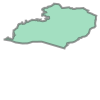

In [ ]:
polygons['geometry'][41]


# Plot another One

In [ ]:
# 1. Pick a polygon ID from the 'index_right' column (e.g., 44)
target_id = 13

# 2. Get the actual polygon geometry
target_polygon_row = polygons.loc[target_id]

# 3. Get all points that matched this specific polygon
matched_points = points_and_polygons[points_and_polygons['index_right'] == target_id]

# 4. Plot them
m = visualize_polygon_with_points(target_polygon_row, matched_points)
display(m)

Map(center=[51.05746508945463, 35.27698968703451], controls=(ZoomControl(options=['position', 'zoom_in_text', …